In [172]:
# Rod length 2d with mass m and moment of intertia I
# gets pushed by perpendicular force f at one end.  
# What's the acceleration of the CofG and the angular acceleration?
# x is along rod, y is perpendicular to rod in direction of f

import sympy as sp
import sympy.physics.mechanics as me

m = sp.symbols("m") # mass of rod
d = sp.Symbol("d")  # half length of rod
x = sp.Symbol("x")  # position along rod
ld = m/(2*d)        # length desnsity
I = sp.integrate(ld*x*x, (x, -d, d))    # moment of inertia evenly distributed
f = sp.Symbol('f')  # instantaneous force


In [173]:
alpha = sp.Symbol("alpha")  # rotational acceleration
a = sp.Symbol("a")          # linear acceleration
eq1 = sp.Eq(alpha*I, f*d)   # rotational torque
eq2 = sp.Eq(m*a, f)         # linear acceleration
sol = sp.solve([eq1, eq2], [a, alpha])
sol

{a: f/m, alpha: 3*f/(d*m)}

In [174]:
deltat = sp.Symbol("\delta t")
vy = (a*deltat + x*alpha*deltat) # velocity forward at position x after infinitesimal time
vy = vy.subs(sol).simplify()
print("vy:")
display(vy)
kineticenergy = sp.integrate(ld/2*vy*vy, (x, -d, d))
workdone = f*vy.subs(x, d)  # force times distance

print("kineticenergy:")
display(kineticenergy)
print("workdone?:")
display(workdone)

vy:


\delta t*f*(d + 3*x)/(d*m)

kineticenergy:


2*\delta t**2*f**2/m

workdone?:


4*\delta t*f**2/m

In [ ]:
# ^^^ why isn't work done same as kineticenergy

In [86]:
# according to section 3 in https://arxiv.org/abs/1708.05062
print("kinetic energy")
linearenergy = (alpha*deltat)**2*I/2
angularenergy = m*(a*deltat)**2/2
KE = (linearenergy + angularenergy).subs(sol).simplify()
KE

kinetic energy


2*\delta t**2*f**2/m

In [164]:
# Next up: express the above in terms of rigid bodies: 
# https://docs.sympy.org/latest/modules/physics/mechanics/masses.html#rigid-body
import sympy as sp
import sympy.physics.mechanics as me

m = sp.Symbol("m")
d = sp.Symbol('d')

lx = sp.Symbol('lx')
z = sp.Symbol('z')
ld = m/(2*d)                         # length density
I = sp.integrate(ld*lx*lx, (lx, -d, d)) # moment of inertia evenly distributed

f = sp.Symbol('f')

t = sp.Symbol('t')
x, y, theta = me.dynamicsymbols('x y theta')
vx, vy, vtheta = me.dynamicsymbols('vx vy vtheta')

BaseFrame = me.ReferenceFrame('BaseFrame')
RodFrame = BaseFrame.orientnew('RodFrame', 'Axis', [theta, BaseFrame.z])
RodFrame.set_ang_vel(BaseFrame, vtheta*BaseFrame.z)
origin  = me.Point('origin')
rodcentre  = origin.locatenew('rodcentre', x*BaseFrame.x + y*BaseFrame.y)
rodcentre.set_vel(BaseFrame, vx*BaseFrame.x + vy*BaseFrame.y)
rodcentre.set_vel(RodFrame, 0)

Izz = me.outer(RodFrame.z, RodFrame.z)*I
rodbody = me.RigidBody(name="rod", masscenter=rodcentre, 
                       frame=RodFrame, mass=m, inertia=(Izz, rodcentre))

rodtip = rodcentre.locatenew('rodtip', d*RodFrame.x)
#rodtip.set_vel(RodFrame, 0)



In [168]:
# https://github.com/sympy/sympy/issues/17761
t = sp.Symbol('t')
rodtip.set_vel(BaseFrame, rodtip.pos_from(origin).diff(t, BaseFrame))

# In that issue is the work-around then to use:
#t = sp.Symbol('t')
#Q.pos_from(P).diff(t, A)  # ~= Q.vel(A)

In [169]:
forces = [ (rodtip, f*RodFrame.y) ]
bodies = [ rodbody ]

xd, yd, thetad = me.dynamicsymbols('x y theta', 1)
kinematic_equations = [vx-xd, vy-yd, vtheta-thetad]

KM = me.KanesMethod(BaseFrame, 
                     q_ind=[x, y, theta], 
                     u_ind=[vx, vy, vtheta],
                     kd_eqs=kinematic_equations)
fr, frstar = KM.kanes_equations(bodies, forces)
display(fr)
display(frstar)

Matrix([
[                           -f*sin(theta(t))],
[                            f*cos(theta(t))],
[f*(d*sin(theta(t))**2 + d*cos(theta(t))**2)]])

Matrix([
[           -m*Derivative(vx(t), t)],
[           -m*Derivative(vy(t), t)],
[-d**2*m*Derivative(vtheta(t), t)/3]])

In [170]:
from pydy.system import System
import numpy as np

initial_conditions = {x:0, y:0, theta:0, 
                      vx:0, vy:0, vtheta:0.}
sys = System(kane,
             constants={m: 1.0, f:3.0 },
             initial_conditions=initial_conditions,
             times=np.linspace(0.0, 3.0, 50))
y1 = sys.integrate()


In [171]:
# no rotation is happening
y1[:,2]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

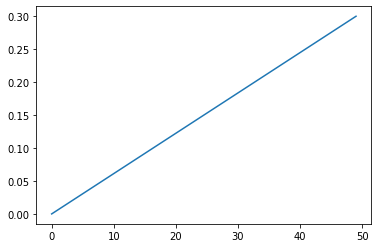

In [161]:
plt.plot(y1[:,2])

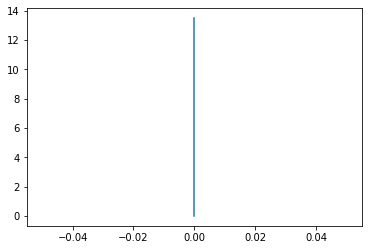

In [148]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(y1[:,0], y1[:,1])
plt.show()


In [91]:
q = me.dynamicsymbols('q')
d = me.dynamicsymbols('d')
A = me.ReferenceFrame('A')
B = A.orientnew('B', 'Axis', (q, A.z))                                                           

P = me.Point('P')                                                                                
Q = P.locatenew('Q', A.y*d)
R = Q.locatenew('R', B.x)

(R.pos_from(P).dot(A.x)*A.x + R.pos_from(P).dot(A.y)*A.y).diff(t, A)
#R.vel(A)


- sin(q)*q'*A.x + (cos(q)*q' + d')*A.y

In [94]:
(R.pos_from(P)).diff(t, A).simplify().dot(A.y)


cos(q(t))*Derivative(q(t), t) + Derivative(d(t), t)

In [89]:
R.pos_from(P)

A.y + B.x

In [83]:
t = sp.Symbol('t')
P = me.Point('P')                                                                                
Q = me.Point('Q')                                                                               
r = q*A.x + 2*q*A.y                                                                             
Q.set_pos(P, q*A.x + 2*q*A.y)    

t = sp.Symbol('t')
display(Q.pos_from(P).diff(t, A))
#Q.vel(A)


q'*A.x + 2*q'*A.y

ValueError: Velocity of point Q has not been defined in ReferenceFrame A

In [ ]:
# Is the work-around then to use:
t = sp.Symbol('t')
Q.pos_from(P).diff(t, A)  # ~= Q.vel(A)


In [128]:
import sympy as sp
import sympy.physics.mechanics as me


m = sp.Symbol('m')
O = me.Point('O')
N = me.ReferenceFrame('N')
P = O.locatenew("P", 3*N.x)
P.set_vel(N, 10*N.y)
Pa = me.Particle('Pa', P, m)

print("linear momentum:")
display(Pa.linear_momentum(N))
print("angular momentum:")
display(Pa.angular_momentum(O, N))
print("kinetic energy:")
display(Pa.kinetic_energy(N))



linear momentum:


10*m*N.y

angular momentum:


30*m*N.z

kinetic energy:


50*m

In [144]:
q = me.dynamicsymbols('q', 1)
q

Derivative(q(t), t)

In [158]:
m, M, l1 = sp.symbols('m M l1')
q = me.dynamicsymbols('q')
N = me.ReferenceFrame('N')
O = me.Point('O')
O.set_vel(N, 0)
Ac = O.locatenew('Ac', l1 * N.x)
P = Ac.locatenew('P', l1 * N.x)
P.pos_from(O)

2*l1*N.x

In [169]:
m, M, l1 = sp.symbols('m M l1')
q = me.dynamicsymbols('q')
N = me.ReferenceFrame('N')
O = me.Point('O')
O.set_vel(N, N.z)
Ac = O.locatenew('Ac', l1 * N.x)
P = Ac.locatenew('P', l1 * N.x)
a = me.ReferenceFrame('a')
a.set_ang_vel(N, q * N.z)

# inherit velocities from the rotation of frame a and velocity of O
Ac.v2pt_theory(O, N, a)
P.v2pt_theory(O, N, a)

Pa = me.Particle('Pa', P, m)
I = me.outer(N.z, N.z)
A = me.RigidBody('A', Ac, a, M, (I, Ac))


In [170]:
I

(N.z|N.z)

In [164]:
help(P.v2pt_theory)

Help on method v2pt_theory in module sympy.physics.vector.point:

v2pt_theory(otherpoint, outframe, fixedframe) method of sympy.physics.vector.point.Point instance
    Sets the velocity of this point with the 2-point theory.
    
    The 2-point theory for point velocity looks like this:
    
    ^N v^P = ^N v^O + ^N omega^B x r^OP
    
    where O and P are both points fixed in frame B, which is rotating in
    frame N.
    
    Parameters
    
    otherpoint : Point
        The first point of the 2-point theory (O)
    outframe : ReferenceFrame
        The frame we want this point's velocity defined in (N)
    fixedframe : ReferenceFrame
        The frame in which both points are fixed (B)
    
    Examples
    
    >>> from sympy.physics.vector import Point, ReferenceFrame, dynamicsymbols
    >>> q = dynamicsymbols('q')
    >>> qd = dynamicsymbols('q', 1)
    >>> N = ReferenceFrame('N')
    >>> B = N.orientnew('B', 'Axis', [q, N.z])
    >>> O = Point('O')
    >>> P = O.locatenew('P'

In [114]:
help(pa)

Help on Particle in module sympy.physics.mechanics.particle object:

class Particle(builtins.object)
 |  Particle(name, point, mass)
 |  
 |  A particle.
 |  
 |  Particles have a non-zero mass and lack spatial extension; they take up no
 |  space.
 |  
 |  Values need to be supplied on initialization, but can be changed later.
 |  
 |  Parameters
 |  ==========
 |  name : str
 |      Name of particle
 |  point : Point
 |      A physics/mechanics Point which represents the position, velocity, and
 |      acceleration of this Particle
 |  mass : sympifyable
 |      A SymPy expression representing the Particle's mass
 |  
 |  Examples
 |  ========
 |  
 |  >>> from sympy.physics.mechanics import Particle, Point
 |  >>> from sympy import Symbol
 |  >>> po = Point('po')
 |  >>> m = Symbol('m')
 |  >>> pa = Particle('pa', po, m)
 |  >>> # Or you could change these later
 |  >>> pa.mass = m
 |  >>> pa.point = po
 |  
 |  Methods defined here:
 |  
 |  __init__(self, name, point, mass)
 |    

In [102]:
#me.linear_momentum, me.angular_momentum
me.linear_momentum(BaseFrame, rodbody)

ValueError: Velocity of point origin has not been defined in ReferenceFrame Base

In [100]:
help(origin.set_vel)

Help on method set_vel in module sympy.physics.vector.point:

set_vel(frame, value) method of sympy.physics.vector.point.Point instance
    Sets the velocity Vector of this Point in a ReferenceFrame.
    
    Parameters
    
    frame : ReferenceFrame
        The frame in which this point's velocity is defined
    value : Vector
        The vector value of this point's velocity in the frame
    
    Examples
    
    >>> from sympy.physics.vector import Point, ReferenceFrame
    >>> N = ReferenceFrame('N')
    >>> p1 = Point('p1')
    >>> p1.set_vel(N, 10 * N.x)
    >>> p1.vel(N)
    10*N.x



In [90]:
# Next up: express the above in terms of rigid bodies: https://docs.sympy.org/latest/modules/physics/mechanics/masses.html#rigid-body
import sympy as sp
import sympy.physics.mechanics as me


m = sp.Symbol("m")
d = sp.Symbol("d")
x = me.dynamicsymbols('x')
z = me.dynamicsymbols('z')

ld = m/(2*d)        # length desnsity
I = sp.integrate(ld*x*x, (x, -d, d))    # moment of inertia evenly distributed


BaseFrame = me.ReferenceFrame('Base')
origin  = me.Point('origin')
origin.set_vel(BaseFrame, 0)

SlabFrame = BaseFrame.orientnew('Slab', 'Axis', [0, BaseFrame.x])
SlabFrame.set_ang_vel(SlabFrame, ythetav * SlabFrame.y)

slabvel = xv*BaseFrame.x + zv*BaseFrame.z
slabpt = origin.locatenew('slab', x*BaseFrame.x + z*BaseFrame.z)
slabpt.set_vel(BaseFrame, slabvel)
Iyy = me.outer(SlabFrame.y, SlabFrame.y)
slabbody = me.RigidBody(name="slab", masscenter=slabpt, frame=SlabFrame, mass=m, 
                        inertia=(Iyy, slabpt))


NameError: name 'ythetav' is not defined

In [ ]:
# Then handle the slipping rod from here:
# https://physics.stackexchange.com/questions/80603/can-i-make-a-rod-in-the-vertical-plane-move-with-its-one-end-on-the-ground-in-a/90894#90894
